## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

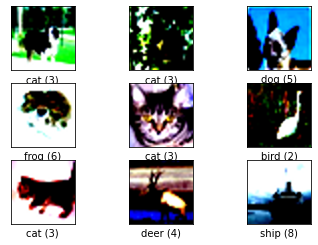

In [4]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [5]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        # Convolution and pooling layers to extract features from the images
        self.feature_extractor = torch.nn.Sequential(
            
          torch.nn.Conv2d(3, 16, kernel_size=(5,5)), # 32 - 5 + 1 = 28
          torch.nn.BatchNorm2d(16),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=(2,2), stride=2), # 28 / 2 = 14

          torch.nn.Conv2d(16, 32, kernel_size=(5,5)), # 14-5+1 = 10
          torch.nn.BatchNorm2d(32),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=(2,2), stride=2), # 10/2=5

          torch.nn.Conv2d(32, 64, kernel_size=(3,3)), # 5-3+1=3
          torch.nn.BatchNorm2d(64),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=(2,2), stride=1) # 10/2=5

        ) # Output : 64x2x2

        # Classification layers
        self.classifier = torch.nn.Sequential(
            
          torch.nn.Linear(64*2*2, 120),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(120, 10)

        )

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################

        x = self.feature_extractor(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [6]:
net = ConvNet()
nb_params = np.sum(np.array([np.prod(param.shape) for param in net.parameters()]))
print('Nb. of parameters in CNN is %s'%(str(nb_params)))

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Nb. of parameters in CNN is 64818


64818

In [7]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.999)

epochs = 10
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################

        optimizer.zero_grad()
        output = net(images)

        lr_scheduler.step()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, labels)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        
        loss.backward()
        optimizer.step()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                pred_val = net(images)
                running_loss = criterion(pred_val, labels)

                # print(torch.argmax(pred_val,dim=1).size())
                accuracy += (torch.argmax(pred_val,dim=1) == labels).sum() / labels.size(0)

                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every),
                  "Learning rate : {:.6f}..".format(optimizer.param_groups[0]['lr'])
                 )
            running_loss = 0
            start = time.time()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWa

Epoch: 1/10.. Loss: 0.0995.. Test accuracy: 0.2311.. 0.0981 s/batch Learning rate : 0.009802..
Epoch: 1/10.. Loss: 0.1156.. Test accuracy: 0.2803.. 0.0538 s/batch Learning rate : 0.009608..
Epoch: 1/10.. Loss: 0.0750.. Test accuracy: 0.3172.. 0.0541 s/batch Learning rate : 0.009417..
Epoch: 1/10.. Loss: 0.0908.. Test accuracy: 0.3217.. 0.0535 s/batch Learning rate : 0.009231..
Epoch: 1/10.. Loss: 0.0796.. Test accuracy: 0.3543.. 0.0541 s/batch Learning rate : 0.009048..
Epoch: 1/10.. Loss: 0.0831.. Test accuracy: 0.3811.. 0.0538 s/batch Learning rate : 0.008869..
Epoch: 1/10.. Loss: 0.0731.. Test accuracy: 0.3562.. 0.0621 s/batch Learning rate : 0.008693..
Epoch: 1/10.. Loss: 0.0642.. Test accuracy: 0.3967.. 0.0816 s/batch Learning rate : 0.008521..
Epoch: 1/10.. Loss: 0.0872.. Test accuracy: 0.4301.. 0.0532 s/batch Learning rate : 0.008352..
Epoch: 1/10.. Loss: 0.0809.. Test accuracy: 0.4584.. 0.0533 s/batch Learning rate : 0.008186..
Epoch: 1/10.. Loss: 0.0804.. Test accuracy: 0.4363

Save best trained model.

In [8]:
torch.save(net.state_dict(), 'drive/MyDrive/Colab Notebooks/CNN_pytorch_3_2_10_epochs.ckpt')